Some prelimary code to visualize tensor-tensor products, the t-SVD, and projections.

In [23]:
# import
import numpy as np
from data.synthetic_data import stripes
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm

Choose an available tensor-tensor product.  Options for this notebook include:

* 'f' : facewise product (no transform along third dimension)
* 't' : t-product (fast Fourier transform along third dimension)
* 'c': c-product (discrete cosine transform along third dimension)

In [24]:
# choose product type {'f', 't', 'c'}
prod_type = 't'

Given a tensor-tensor product $\star_M$, the projection of a tensor $\mathcal{A}$
onto the space spanned by the lateral slices of a tensor $\mathcal{U}$ is

$$\mathcal{U} \star_M \mathcal{U}^\top \star_M \mathcal{A}$$

In [25]:
def projection(A, U, prod_type):
    training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
    return tp.ten_prod(U, training_coeff, prod_type=prod_type)


The data is composed of $n\times n$ images with four different possible "stripes" of the same width.
Let ${\bf e} \in \mathbb{R}^n$ be the vector of all ones.  Let ${\bf x}, {\bf y}\in \mathbb{R}^n$ be random vectors.
Here, $\otimes$ denotes the Kronecker product.

* 'vertical' : $\mathbf{e}^\top \otimes \mathbf{x}$
* 'horizontal' : $\mathbf{x}^\top \otimes \mathbf{e}$
* 'main_diagonal' : $\text{toeplitz}({\bf x}, {\bf y})$ (constant from top left to bottom right)
* 'off_diagonal' : $\text{rot90}(\text{toeplitz}({\bf x}, {\bf y}), 1)$ (constant from top right to bottom left)

The data is stored as an $n \times M\times n$ tensor where $M$ is the number of images.

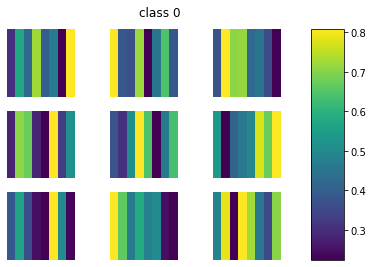

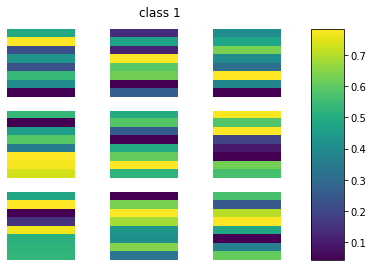

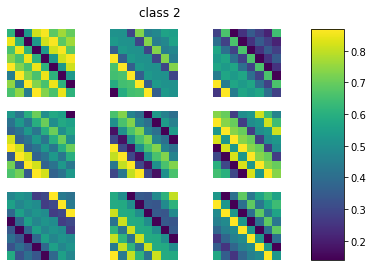

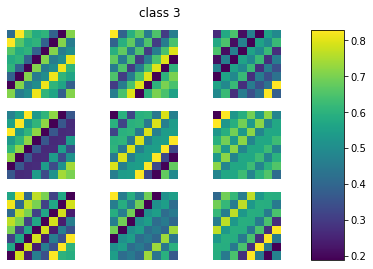

(8, 36, 8)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [26]:
# for reproducibility
np.random.seed(20)

# load data
img_shape = (8, 8)
num_classes = 4
training_data, training_labels = stripes(num_images_per_class=100, img_shape=img_shape, num_classes=num_classes)
test_data, test_labels = stripes(num_images_per_class=9, img_shape=img_shape, num_classes=num_classes)

# permute such that lateral slices are the images
training_data = training_data.transpose(0, 2, 1)
test_data = test_data.transpose(0, 2, 1)

# visualize data
for i in range(num_classes):
    slice_subplots(test_data[:, test_labels == i, :], axis=1, title='class ' + str(i))
    plt.show()

print(test_data.shape)
print(test_labels)

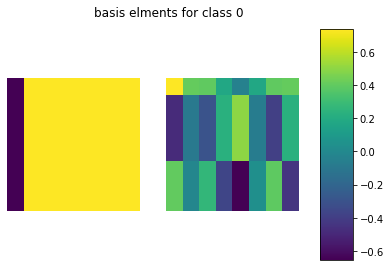

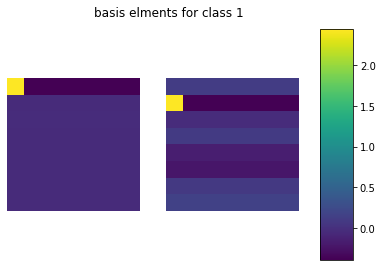

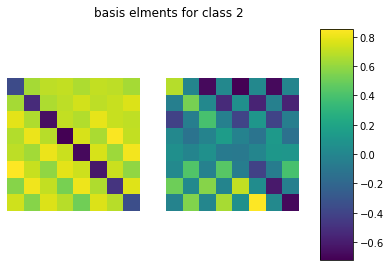

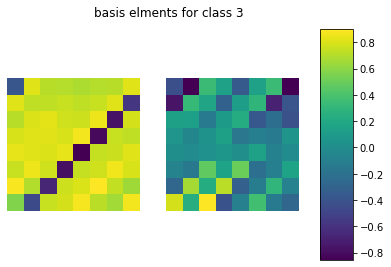

In [27]:
# form local t-svd
num_classes = len(np.unique(training_labels))
k = 2

U = []
for i in range(num_classes):
    u, _, _, _ = tp.ten_svd(training_data[:, training_labels == i, :], k, prod_type=prod_type)
    U.append(u)

# visualizations
for i in range(num_classes):
    slice_subplots(U[i], axis=1, title='basis elments for class ' + str(i))
    plt.show()

train accuracy = 85.50
test accuracy = 88.89


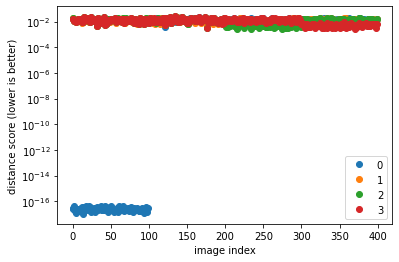

In [28]:
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results
training_num_correct = np.sum(training_predicted_classes == training_labels)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == test_labels)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

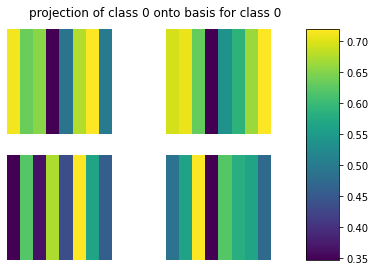

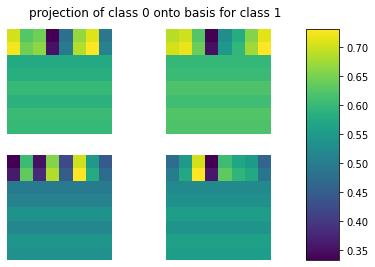

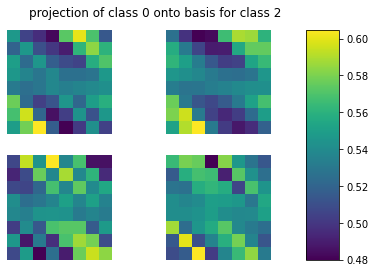

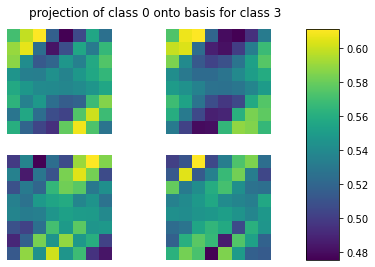

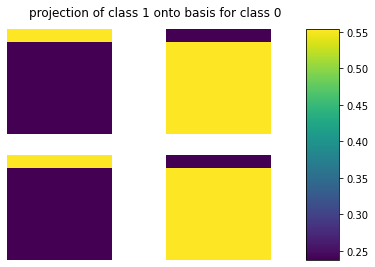

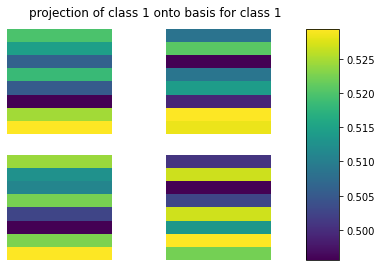

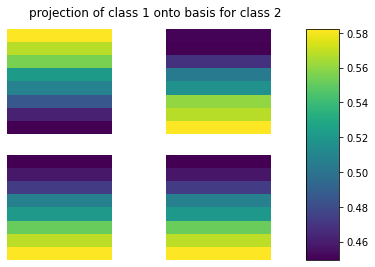

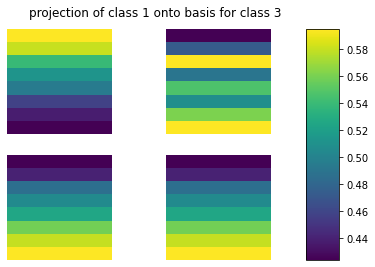

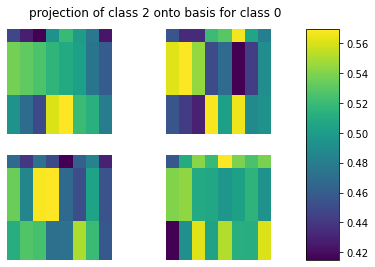

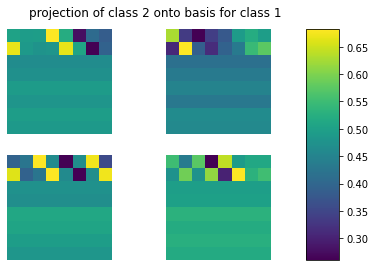

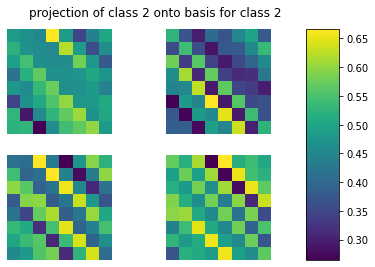

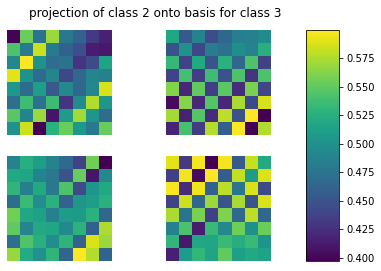

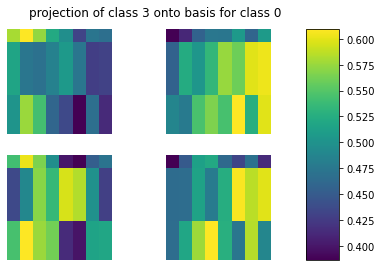

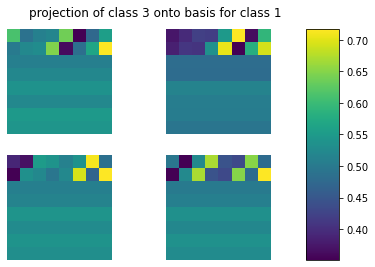

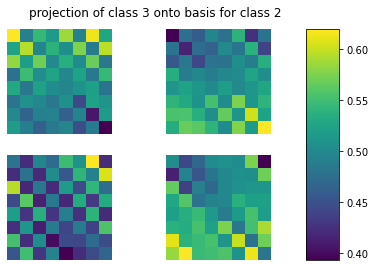

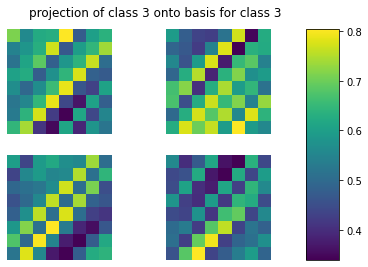

In [29]:
# visualizations of projected tensors
for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:, training_labels == j, :], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()




